In [1]:
import pandas as pd
import numpy as np
from scipy import optimize

In [2]:
sam_df = pd.read_csv('../data/sam/state_sams/Alabama_2015.csv', index_col = 0)

In [3]:
# Generate matrix from sam
sam_mat = np.matrix(sam_df)

In [4]:
# # Random matrix for testing
# temp = np.matrix(np.random.random((4,4)))*1.2
# sam_mat_true = np.round(temp + temp.T, 0).astype(int)
# sam_mat = sam_mat_true
# sam_mat[:,1] = 0
# sam_mat[1,:] = 0
# sam_mat 

In [5]:
# Column sums
y = np.sum(sam_mat, axis = 0).T

In [6]:
# Coefficient matrix
A = np.divide(sam_mat, y.T, where = (y.T != 0))
A[:, np.where(y.T == 0)[1]] = 0
A_original = A.copy()

n = np.shape(A)[0]

In [7]:
def kl_divergence(mat_b):
    mat_a = A_original
    mat_b = np.matrix(np.reshape(mat_b, (n,n)))
    
    # Divide matrices where we don't have zeros
    mat_div = np.divide(mat_b, mat_a, where = ((mat_a*100).astype(int) != 0))
    
    # Replace 0's with 1's which will become 0's when logged
    mat_div[mat_div == 0] = 1
    
    return np.sum(np.multiply(mat_b, np.log(mat_div)))

def row_col_constraint(A):    
    A = np.matrix(np.reshape(A, (n,n)))
    return np.sum(np.square(np.dot(A, y) - y))

def coeff_constraint(A):
    A = np.matrix(np.reshape(A, (n,n)))
    
    # Get squared differences from A column sums and 1 
    sq_error = np.array(np.square(np.sum(A, axis = 0) - 1)).flatten()
    
    # Ignore error terms where A is 0 (indicates 0 row/col in SAM)
    sq_error[np.where(np.sum(A, axis = 0) == 0)[1]] = 0
    
    return np.sum(sq_error)

In [8]:
print(row_col_constraint(A))
print(coeff_constraint(A))

301888467519.16077
2.711709361697228e-31


In [9]:
# Bound all values between [0,1], bound zeros to zero
bound_array = np.array([(0,1)]*(n**2))
bound_array[np.where(np.array(np.reshape(A_original, (n**2)) == 0).flatten())] = (0,0)

# Constraints
con_1 = optimize.NonlinearConstraint(coeff_constraint,   0, 1e2)
con_2 = optimize.NonlinearConstraint(row_col_constraint, 0, 1e8)

In [10]:
# Initial guess

In [359]:
sam_mat_temp = sam_mat.copy()

In [366]:
track_list = []

for t in range(100):

    div_differences = np.divide(sam_mat_temp.sum(axis = 1).T, sam_mat_temp.sum(axis = 0), where = (sam_mat_temp.sum(axis = 0) != 0))

    for i in range(n):
        sam_mat_temp[:,i] = sam_mat_temp[:,i]*div_differences[0,i]

    div_differences = np.divide(sam_mat_temp.sum(axis = 0).T, sam_mat_temp.sum(axis = 1), where = (sam_mat_temp.sum(axis = 1) != 0))

    for i in range(n):
        sam_mat_temp[i,:] = sam_mat_temp[i,:]*div_differences[i,0]


    #print(np.divide(sam_mat_temp.sum(axis = 0).T, sam_mat_temp.sum(axis = 1), where = (sam_mat_temp.sum(axis = 1) != 0)))

    track_list.append([t, np.sum(np.square(np.add(sam_mat_temp.sum(axis = 0).T, -sam_mat_temp.sum(axis = 1))))])

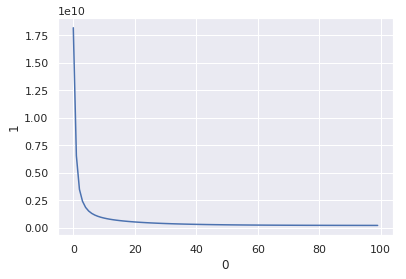

In [365]:
# import seaborn as sns; sns.set();
# sns.lineplot(x = 0, y = 1, data = pd.DataFrame(track_list))

In [ ]:
result = optimize.minimize(kl_divergence, np.reshape(np.array(A), (n**2)), 
                           constraints = (con_1, con_2), bounds = bound_array,
                           options = {'disp': True, 'maxiter': 10})
result

In [976]:
print(coeff_constraint(result.x))
print(row_col_constraint(result.x))

97.69723604683855
160191793642.6488


In [977]:
A_opt = np.reshape(result.x, (n,n))
A_opt[A_opt == 1] = 0

sam_mat_bal = np.multiply(A_opt, y.T) 

In [978]:
sam_mat_bal

matrix([[1.52526403e-03, 4.62972502e+03, 9.65473318e+04, ...,
         2.03675610e-02, 0.00000000e+00, 0.00000000e+00],
        [1.47336234e-03, 9.96581346e-03, 8.61682441e+01, ...,
         3.16603659e-02, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 4.62652171e+03, 1.07375841e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [979]:
sam_mat_bal.sum(axis = 0).T - sam_mat_bal.sum(axis = 1)

matrix([[-1.12591658e+05],
        [-1.45560316e+04],
        [-2.18977268e+04],
        [-5.79550281e+04],
        [ 6.12675384e+04],
        [-1.79887938e+04],
        [-7.32439563e+04],
        [-6.61332606e+03],
        [-9.18629928e+02],
        [-2.57584980e+03],
        [-4.05889351e+04],
        [-3.83813745e+04],
        [-6.51227709e+00],
        [-1.10103558e+04],
        [ 6.88144755e+04],
        [-6.09650781e+03],
        [-1.00118222e+04],
        [ 2.02893501e+05],
        [-1.13763381e+04],
        [-1.03846141e+03],
        [-1.10536002e+05],
        [-1.16293702e+04],
        [-2.00905358e+05],
        [-3.65870413e+03],
        [ 2.46444652e+04],
        [-2.36628888e+03],
        [ 5.80418375e+04],
        [ 2.51077615e+05],
        [ 2.03266964e-01],
        [ 9.17365458e+04],
        [-2.79185516e+03],
        [ 0.00000000e+00],
        [ 2.62704348e+02]])